In [1]:
import numpy as np
from facial_data import load_clean_training_data

X_train, y_train = load_clean_training_data('training.csv', 3000)

# transform X_train, y_train to numpy arrays
X_train = np.array(X_train).reshape((-1, 96, 96, 1))
y_train = np.array(y_train)

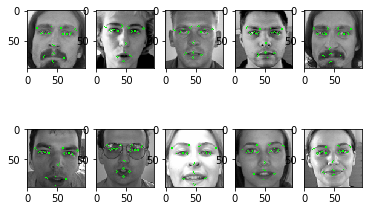

In [2]:
# 畫幾張圖來瞧瞧

import cv2
import copy
from matplotlib import pyplot as plt
%matplotlib inline

some_images_to_show = []
for k in range(10):
    test_img = X_train[k].reshape((96, 96)).astype(np.uint8) # or 'uint8', cannnot be int
    test_img = np.stack([test_img]*3, axis=2)
    plt.subplot(2, 5, k+1)
    for i in range(15):
        x = int(y_train[k][2*i])
        y = int(y_train[k][2*i+1])        
        cv2.circle(test_img, center=(x,y), radius=2, color=(0, 255, 0), thickness=1)        
    plt.imshow(test_img)


In [15]:
# pre-process

# 取n_train出來當training data, 剩下的當validation
n_train = len(X_train) - 1
n_valid = len(X_train) - n_train

X_valid = X_train[n_train:]
y_valid = y_train[n_train:]
X_train = X_train[0:n_train]
y_train = y_train[0:n_train]

# zero-centering: minus mean
preprocess_mean = np.mean(X_train)
X_train -= preprocess_mean
X_valid -= preprocess_mean

# normalization: divided by standard deviation
preprocess_std = np.std(X_train)
X_train /= preprocess_std
X_valid /= preprocess_std

# for y: no need to do any pre-process

print('X_train.shape =', X_train.shape)
print('y_train.shape =', y_train.shape)
print('X_valid.shape =', X_valid.shape)
print('y_valid.shape =', y_valid.shape)
print('preprocess_mean =', preprocess_mean)
print('preprocess_std =', preprocess_std)

X_train.shape = (2139, 96, 96, 1)
y_train.shape = (2139, 30)
X_valid.shape = (1, 96, 96, 1)
y_valid.shape = (1, 30)
preprocess_mean = 121.07458845482053
preprocess_std = 59.07326817559375


In [16]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras import optimizers
from keras import regularizers

def simple_cnn():
    model = Sequential()
    
    reg = regularizers.l2(0.00)
    
    model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=reg, input_shape=(96, 96, 1)))
    model.add(Activation('relu'))  
    
    model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=reg))
    model.add(Activation('relu'))        
    
    model.add(MaxPooling2D())    
    
    model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=reg))
    model.add(Activation('relu'))
    
    model.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=reg))
    model.add(Activation('relu'))
            
    model.add(MaxPooling2D())
#     model.add(Dropout(rate=0.1))

    model.add(Flatten())    
    model.add(Dropout(rate=0.2))
    model.add(Dense(30, kernel_regularizer=reg))
    model.add(Activation('linear'))    
    
    optimizer = optimizers.Adam()
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

Using TensorFlow backend.


In [22]:
# clear previous gpu memory
import gc
from keras import backend as K
K.clear_session()
gc.collect()

119

In [23]:
simple_cnn_model = simple_cnn()

print(simple_cnn_model.summary())

# hist = simple_cnn_model.fit(X_train, y_train, batch_size=32, epochs=20, validation_split=0.2)
# hist = simple_cnn_model.fit(X_train, y_train, batch_size=16, epochs=30, validation_data=(X_valid, y_valid))
hist = simple_cnn_model.fit(X_train, y_train, batch_size=16, epochs=30, validation_data=(X_train, y_train))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
activation_3 (Activation)    (None, 48, 48, 32)        0         
__________

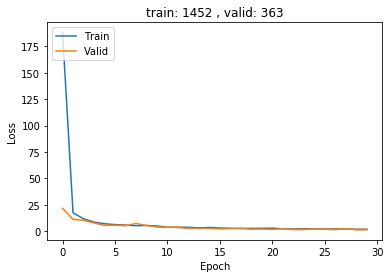

In [24]:
# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('train: 1452 , valid: 363')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [25]:
# save the model to file

simple_cnn_model.save('simple_cnn_model.h5')

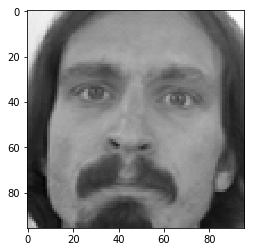

In [26]:
# x_test = X_valid[5]
x_test = X_train[0]
y_true = y_train[0]
y_test = simple_cnn_model.predict(x_test.reshape((1,96,96,1)))

test_img = x_test.reshape((96, 96)) * preprocess_std + preprocess_mean
test_img = np.stack([test_img]*3, axis=2).astype('uint8')
for i in range(15):
    x = int(y_test[0][2*i])
    y = int(y_test[0][2*i+1])
    cv2.circle(test_img, center=(x,y), radius=1, color=(0, 255, 0), thickness=1)
    x = int(y_true[2*i])
    y = int(y_true[2*i+1])
    cv2.circle(test_img, center=(x,y), radius=1, color=(255, 0, 0), thickness=1)
plt.imshow(test_img)

In [5]:
# load pre-trained model

import numpy as np
from keras.models import load_model

simple_cnn_model = load_model('simple_cnn_model.h5')

Using TensorFlow backend.


In [6]:
# load test data

from facial_data import load_test_data, load_feature_dictionary

feature_dict = load_feature_dictionary()

X_test = load_test_data('test.csv')
X_test = np.array(X_test).reshape((-1, 96, 96, 1))
print('X_test.shape = ', X_test.shape)

# pre-process
X_test -= preprocess_mean
X_test /= preprocess_std

X_test.shape =  (1783, 96, 96, 1)


In [7]:
# predict test data

y_pred = simple_cnn_model.predict(X_test)
print('y_pred.shape = ', y_pred.shape)

y_pred.shape =  (1783, 30)


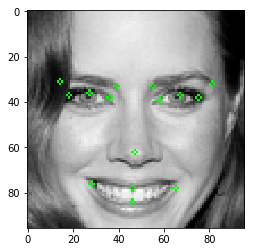

In [24]:
x_test = X_test[500]
y_test = simple_cnn_model.predict(x_test.reshape((1,96,96,1)))

test_img = x_test.reshape((96, 96)) * preprocess_std + preprocess_mean
test_img = np.stack([test_img]*3, axis=2).astype('uint8')
for i in range(15):
    x = int(y_test[0][2*i])
    y = int(y_test[0][2*i+1])
    cv2.circle(test_img, center=(x,y), radius=1, color=(0, 255, 0), thickness=1)
plt.imshow(test_img)

In [9]:
# write output 

from facial_data import write_output

write_output('output1.csv', y_pred)